In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style="darkgrid")

load = pd.read_csv('data/load.csv')

# Data preprocessing

In [20]:
# takes 1-2 minutes to execute
def df_formatting(df):
    """
    Input: dataframe in the load.csv format
    Output: two dataframes with a line per meter_id, with the following columns
    - meter_id
    - timesteps: array of timesteps
    - load: array of load values
    The train dataset goes up to the end of 2010, and the test df contains the whole 2011 year
    """
    new_df_train = pd.DataFrame(columns=['meter_id', 'timesteps', 'load'])
    new_df_test = pd.DataFrame(columns=['meter_id', 'timesteps', 'load'])
    meter_id = 0
    timesteps_train, load_train = "", ""
    timesteps_test, load_test = "", ""
    for _,line in df.iterrows():
        current_id = line['meter_id']
        if current_id != meter_id:
            if meter_id != 0:
                new_df_train = new_df_train.append({'meter_id': meter_id, 'timesteps': timesteps_train, 'load': load_train}, ignore_index=True)
                new_df_test = new_df_test.append({'meter_id': meter_id, 'timesteps': timesteps_test, 'load': load_test}, ignore_index=True)
            meter_id = current_id
            timesteps_train, load_train = [], []
            timesteps_test, load_test = [], []
        for hour in range(1, 25):
            month, day, year = line['date'].split('/')
            if int(year) < 2011:
                timesteps_train.append(datetime(int(year), int(month), int(day), hour - 1, 0))
                load_train.append(line['h'+str(hour)])
            else:
                timesteps_test.append(datetime(int(year), int(month), int(day), hour - 1, 0))
                load_test.append(line['h'+str(hour)])
    return new_df_train, new_df_test

train, test = df_formatting(load)

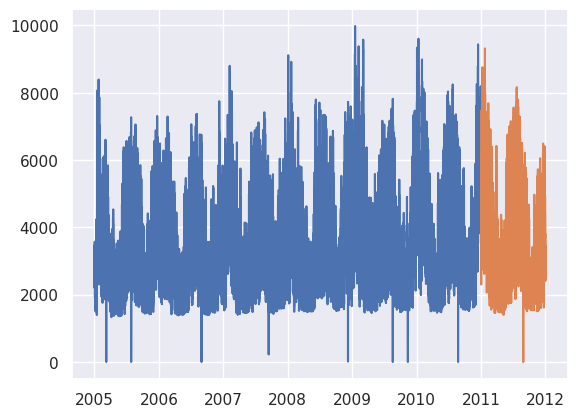

In [21]:
plt.plot(train.iloc[0]['timesteps'], train.iloc[0]['load'])
plt.plot(test.iloc[0]['timesteps'], test.iloc[0]['load'])
plt.show()

In [22]:
train.to_csv('data_preproc/load_train.csv', index=False)
test.to_csv('data_preproc/load_test.csv', index=False)

# SARIMA parameter search

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


We choose the SARIMA hyperparameters over 2009-2011 but will fit the model on 2005-2011

In [8]:
X_train1 = train.iloc[0]['timesteps'][-365*24*2:]
y_train1 = train.iloc[0]['load'][-365*24*2:]
X_test1 = test.iloc[0]['timesteps']
y_test1 = test.iloc[0]['load']

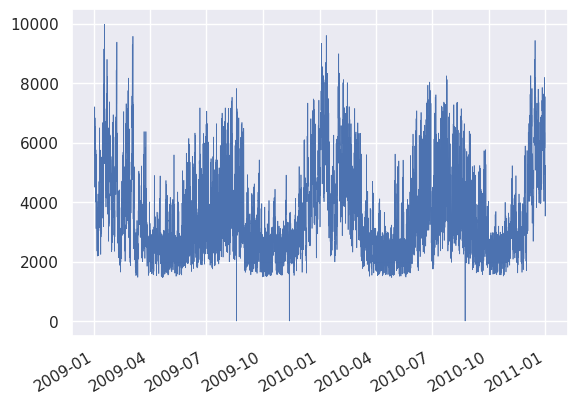

In [9]:
fig, ax = plt.subplots()
ax.plot(X_train1, y_train1, linewidth=0.5)
fig.autofmt_xdate()

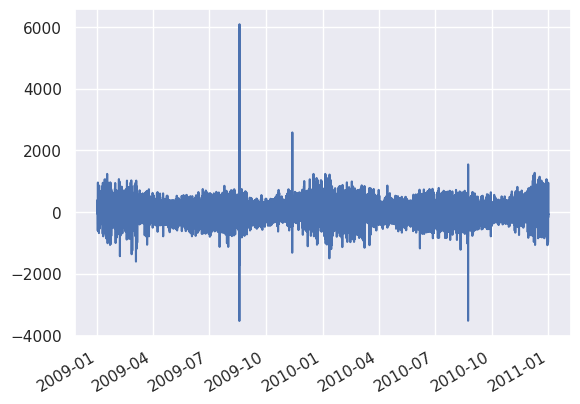

In [10]:
# order 1 differencing to remove trend
train_df = pd.DataFrame({'load': y_train1, 'timesteps': X_train1})
train_df['load_diff'] = train_df['load'].diff()
fig, ax = plt.subplots()
ax.plot(train_df['timesteps'], train_df['load_diff'])
fig.autofmt_xdate()

d = 1 makes the series stationnary


/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


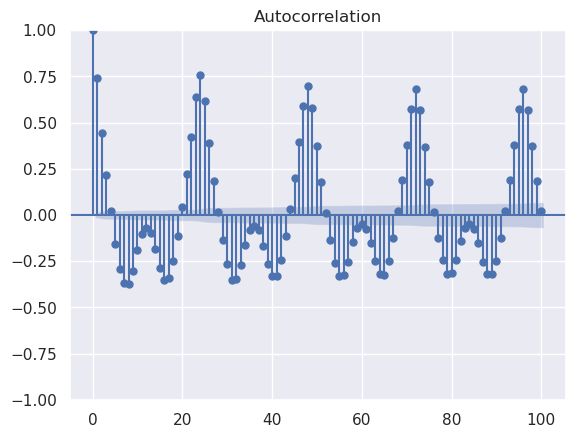

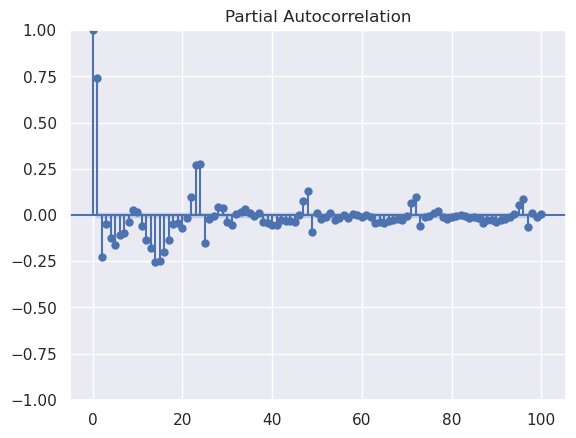

In [11]:
plot_acf(train_df['load_diff'].dropna(), lags=100)
out = plot_pacf(train_df['load_diff'].dropna(), lags=100)

We should take S = 24 as we observe temporality in the graphs. 

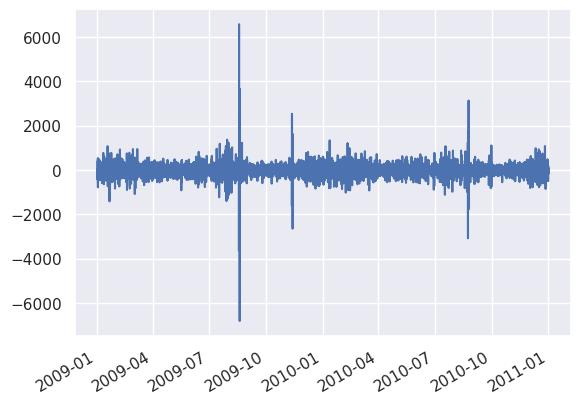

In [12]:
train_df['load_diff_ds'] = train_df['load_diff'].diff(24).dropna()
fig, ax = plt.subplots()
ax.plot(train_df['timesteps'], train_df['load_diff_ds'])
fig.autofmt_xdate()

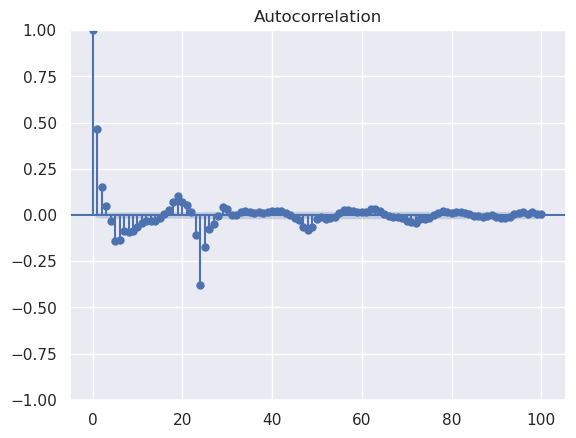

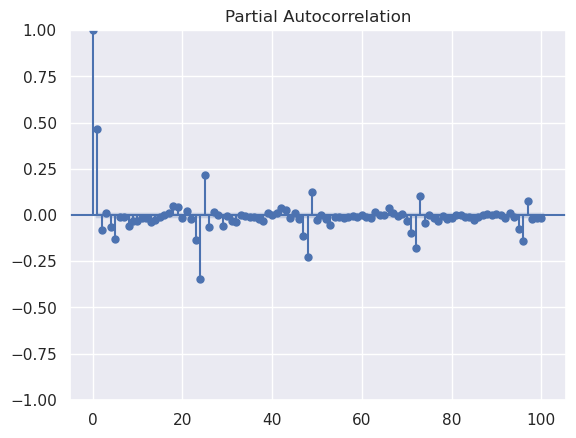

In [13]:
plot_acf(train_df['load_diff_ds'].dropna(), lags=100)
out = plot_pacf(train_df['load_diff_ds'].dropna(), lags=100)

# SARIMA fitting on one time-series

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# we go back to our whole train dataset
X_train1 = train.iloc[0]['timesteps']
y_train1 = train.iloc[0]['load']
X_test1 = test.iloc[0]['timesteps']
y_test1 = test.iloc[0]['load']

# order 1 differencing to remove trend
train_df = pd.DataFrame({'load': y_train1, 'timesteps': X_train1})
train_df['load_diff'] = train_df['load'].diff()
test_df = pd.DataFrame({'load': y_test1, 'timesteps': X_test1})
test_df['load_diff'] = test_df['load'].diff()
# drop the nan values
train_df = train_df.dropna()
test_df = test_df.dropna()

# order 24 differencing to remove seasonality
train_df['load_diff_ds'] = train_df['load_diff'].diff(24).dropna()
test_df['load_diff_ds'] = test_df['load_diff'].diff(24).dropna()
# drop the nan values
train_df = train_df.dropna()
test_df = test_df.dropna()

# # convert the datetimes to timestamps
# train_df['timesteps'] = train_df['timesteps'].apply(lambda x: x.timestamp())

# # input for SARIMA
# X_train = train_df['timesteps']
# y_train = train_df['load_diff_ds']
# X_test = test_df['timesteps']
# y_test = test_df['load_diff_ds']


NameError: name 'train' is not defined

In [24]:
train_df = train_df[['timesteps', 'load_diff_ds']]
test_df = test_df[['timesteps', 'load_diff_ds']]

train_df = train_df.set_index('timesteps')
test_df = test_df.set_index('timesteps')

We don't observe any decay to we choose (1,1) x (1,1)

In [19]:
len(train_df)

52547

In [20]:
model = SARIMAX(train_df[:10000], order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24),
        freq = None
    ).fit()
print(model.summary())


/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94433D+00    |proj g|=  4.15773D-02

At iterate    5    f=  6.91106D+00    |proj g|=  1.35475D-02

At iterate   10    f=  6.90012D+00    |proj g|=  2.26999D-03

At iterate   15    f=  6.56397D+00    |proj g|=  3.29059D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     36      1     0     0   1.378D-03   6.563D+00
  F =   6.5630813589940926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

In [21]:
model.aic

131271.62717988185

In [22]:
model.bic

131307.66636609065

In [23]:
model = SARIMAX(train_df, order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24),
        freq = None
    ).fit()
print(model.summary())

/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95886D+00    |proj g|=  4.06900D-02

At iterate    5    f=  6.92393D+00    |proj g|=  1.55338D-02

At iterate   10    f=  6.90952D+00    |proj g|=  5.39120D-03

At iterate   15    f=  6.69421D+00    |proj g|=  4.32410D-02

At iterate   20    f=  6.67862D+00    |proj g|=  1.29789D-02

At iterate   25    f=  6.67856D+00    |proj g|=  1.17242D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     61      1     0     0   

: 

# Top series detrending

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



load_df = pd.melt(load, id_vars=["meter_id", "date"], value_vars=load.columns.difference(["meter_id", "date"]), 
                                var_name="hour", value_name="load")
load_df["hour"] = load_df["hour"].str.strip("h").astype(int) - 1
load_df["timestamp"] = pd.to_datetime(load_df["date"] + " " + load_df["hour"].astype(str) + ":00:00", format="%m/%d/%Y %H:%M:%S")
load_df["meter_id"] = load_df["meter_id"].astype(int)
load_df = load_df.drop(columns=["date", "hour"])

# sum load, group by timestamp
load_df = load_df.groupby("timestamp").sum().reset_index()

# substract mean and divide by max 
load_df["load"] = (load_df["load"] - load_df["load"].mean()) / load_df["load"].max()

In [3]:
# use statsmodel seasonal decomposition to remove seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

df_decomp = load_df[['timestamp', 'load']]  
df_decomp.index = df_decomp['timestamp']
decomposition = seasonal_decompose(df_decomp["load"])

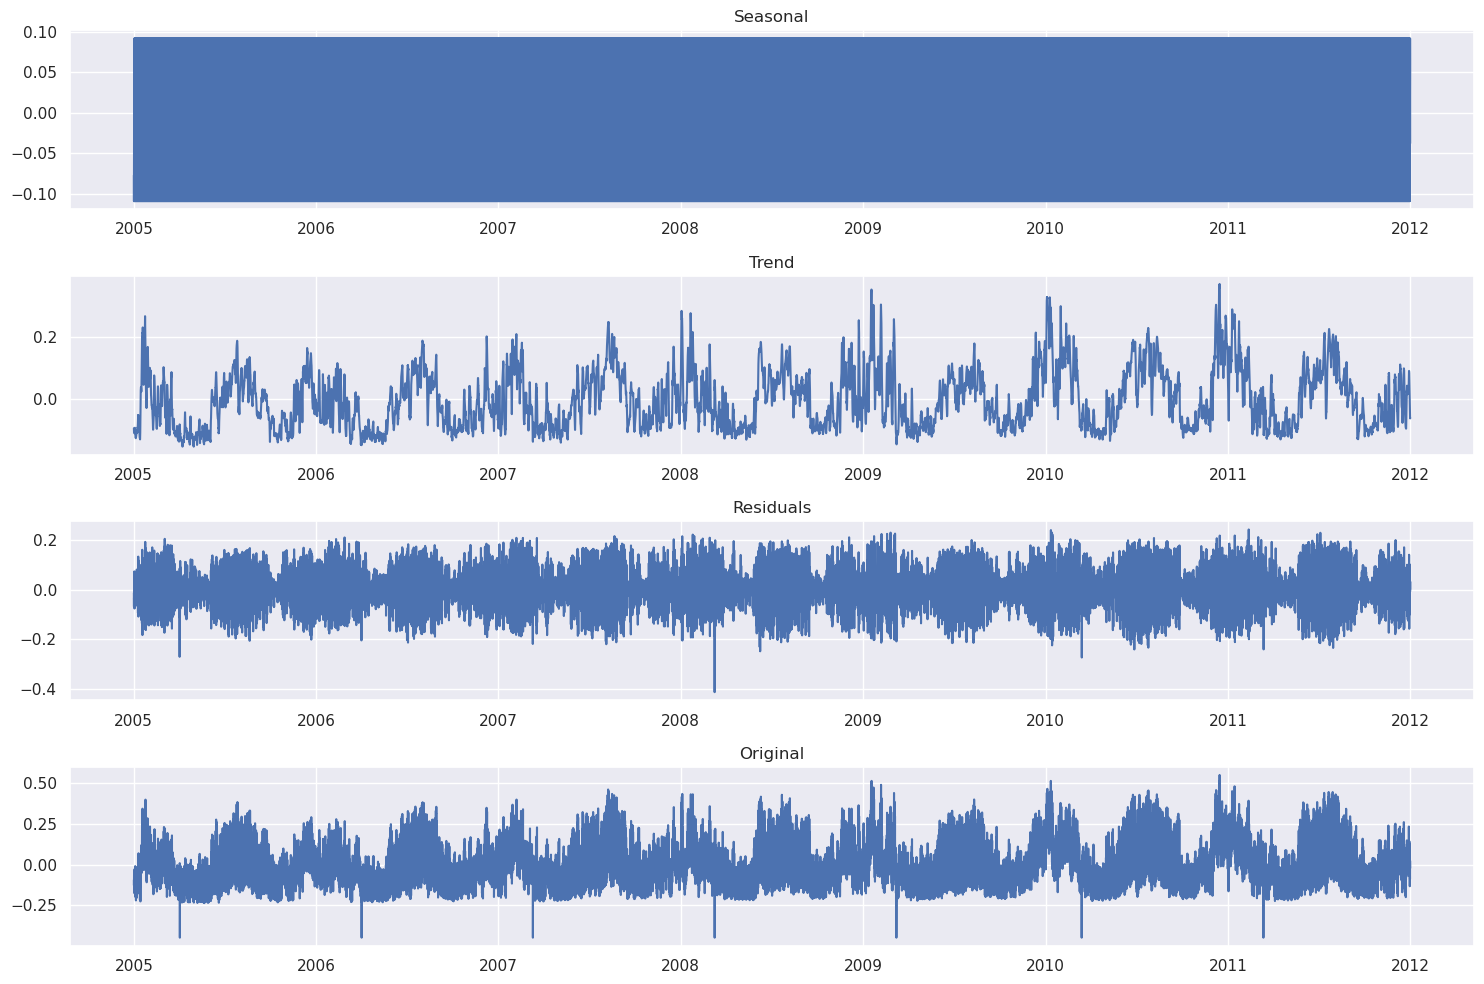

In [4]:


# plot seasonal, trend and residuals
fig, ax = plt.subplots(4,1, figsize=(15,10))
ax[0].plot(load_df["timestamp"], decomposition.seasonal)
ax[0].set_title("Seasonal")
ax[1].plot(load_df["timestamp"], decomposition.trend)
ax[1].set_title("Trend")
ax[2].plot(load_df["timestamp"], decomposition.resid)
ax[2].set_title("Residuals")
ax[3].plot(load_df["timestamp"], load_df["load"])
ax[3].set_title("Original")
plt.tight_layout()
plt.show()


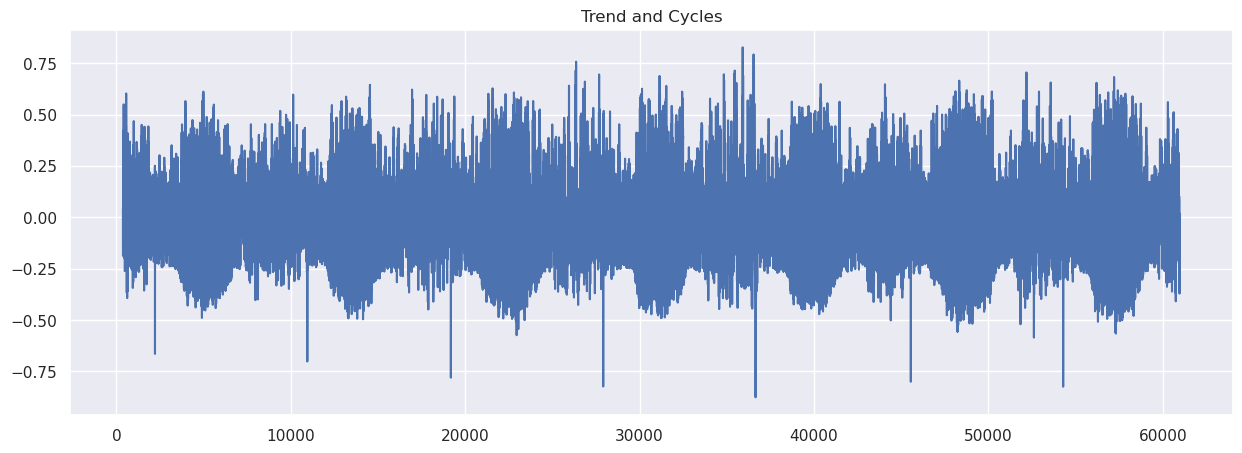

In [10]:
# apply bkfilter
from statsmodels.tsa.filters.bk_filter import bkfilter
cycles = bkfilter(load_df["load"], low=1, high=370, K=370)

# plot trend and cycles
cycles.plot(figsize=(15,5))
plt.title("Trend and Cycles")
plt.show()

In [42]:
len(cycles)

60604

In [40]:
load_df.head()

,timestamp,meter_id,load,load_decycled
0,2005-01-01 00:00:00,29496,-0.094623,NaN
1,2005-01-01 01:00:00,29496,-0.110216,NaN
2,2005-01-01 02:00:00,29496,-0.123344,NaN
3,2005-01-01 03:00:00,29496,-0.127727,NaN
4,2005-01-01 04:00:00,29496,-0.125559,NaN


In [41]:
# select lines of load_df for which the timestamp is in cycles
load_df2 = load_df[load_df["timestamp"].isin(cycles.index)]
len(load_df2)

0

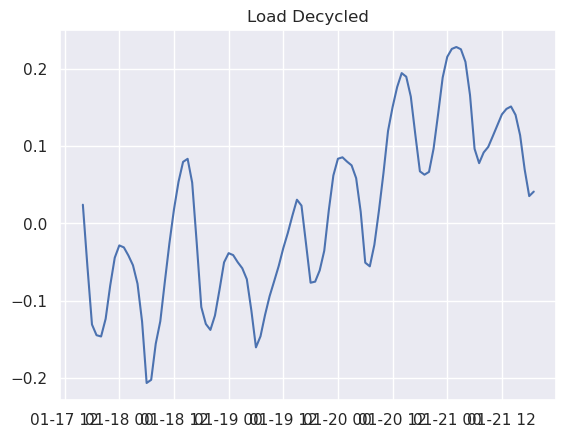

In [43]:
# remove cyles from original data
load_df["load_decycled"] = load_df["load"] - cycles

# plot decycled data
plt.plot(load_df.iloc[400:500]["timestamp"], load_df.iloc[400:500]["load_decycled"])
plt.title("Load Decycled")
plt.show()


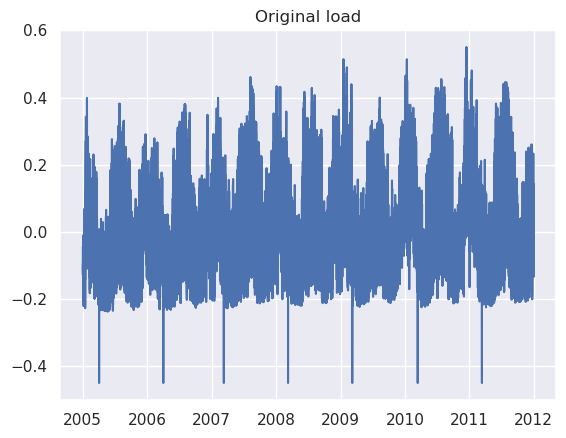

In [22]:
plt.plot(load_df.iloc[:100]["timestamp"], load_df.iloc[:100]["load"])
plt.title("Original load")
plt.show()


# SARIMA benchmarking on the top time-series

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



load_df = pd.melt(load, id_vars=["meter_id", "date"], value_vars=load.columns.difference(["meter_id", "date"]), 
                                var_name="hour", value_name="load")
load_df["hour"] = load_df["hour"].str.strip("h").astype(int) - 1
load_df["timestamp"] = pd.to_datetime(load_df["date"] + " " + load_df["hour"].astype(str) + ":00:00", format="%m/%d/%Y %H:%M:%S")
load_df["meter_id"] = load_df["meter_id"].astype(int)
load_df = load_df.drop(columns=["date", "hour"])

In [3]:
# sum load, group by timestamp
load_df = load_df.groupby("timestamp").sum().reset_index()

# substract mean and divide by max 
load_df["load"] = (load_df["load"] - load_df["load"].mean()) / load_df["load"].max()

# split train test
train_df = load_df[load_df["timestamp"] < "2011-01-01"]
test_df = load_df[load_df["timestamp"] >= "2011-01-01"]

# take the log of the load
train_df["load"] = np.log(train_df["load"])
test_df["load"] = np.log(test_df["load"])

# order 1 differencing to remove trend
train_df['load_diff'] = train_df['load'].diff()
test_df['load_diff'] = test_df['load'].diff()
# drop the nan values
train_df = train_df.dropna()
test_df = test_df.dropna()

# order 24 differencing to remove seasonality
train_df['load_diff_ds'] = train_df['load_diff'].diff(24).dropna()
test_df['load_diff_ds'] = test_df['load_diff'].diff(24).dropna()
# drop the nan values
train_df = train_df.dropna()
test_df = test_df.dropna()




/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nyss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/home/nyss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/nyss/.local/lib/python3.7/site-packages

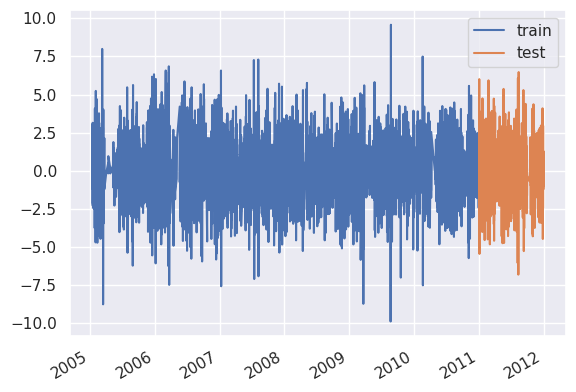

In [4]:
# plot test and train on the same graph
fig, ax = plt.subplots()
ax.plot(train_df['timestamp'], train_df['load_diff_ds'], label='train')
ax.plot(test_df['timestamp'], test_df['load_diff_ds'], label='test')
fig.autofmt_xdate()
plt.legend()

/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


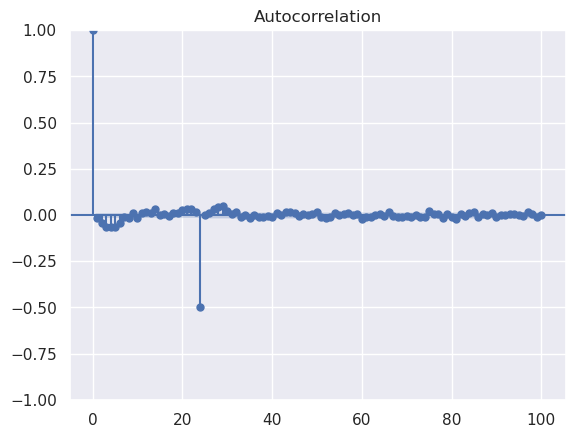

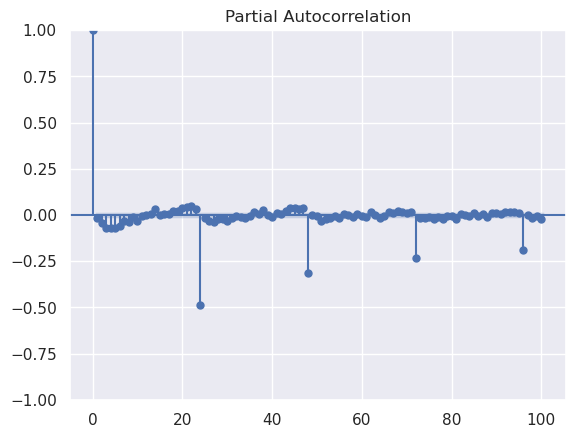

In [5]:
# plot acf and pacf
plot_acf(train_df['load_diff_ds'].dropna(), lags=100)
out = plot_pacf(train_df['load_diff_ds'].dropna(), lags=100)


We observe a 24 period in the PACF and ACF. \
For the seasonal part, we do not observe any decay in the ACF, and we observe \
For the non seasonal part, we do not observe any decay.

In [14]:
train_df = train_df[['timestamp', 'load']]
test_df = test_df[['timestamp', 'load']]
train_df = train_df.set_index('timestamp')
test_df = test_df.set_index('timestamp')

In [12]:
orders = [(1, 1, 1, ), (1, 1, 0, 1), (1, 1, 1, 1), (1, 0, 1, 1), (0, 1, 1, 1)]
orders = [(1,1,1,1)]

aic_values = []
bic_values = []

for p, q, P, Q in orders:
    model = SARIMAX(train_df[-1000:], order=(p, 1, q),
        seasonal_order=(P, 1, Q, 24),
        freq = None
    ).fit()
    aic_values.append(model.aic)
    bic_values.append(model.bic)
    print(f'ARMA {p},{0}, {q}x{P},{0},{Q} - AIC: {model.aic:.2f}, BIC: {model.bic:.2f}')


best_aic_index = aic_values.index(min(filter(None, aic_values)))
best_bic_index = bic_values.index(min(filter(None, bic_values)))

best_aic_model = orders[best_aic_index]
best_bic_model = orders[best_bic_index]

print(f'\nBest Model based on AIC: ARMA {best_aic_model[0]} {best_aic_model[1]} {best_aic_model[2]} {best_aic_model[3]}')
print(f'Best Model based on BIC: ARMA {best_bic_model[0]} {best_bic_model[1]} {best_bic_model[2]} {best_bic_model[3]}')

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen weretimestamp       datetime64[ns]
meter_id                 int64
load                   float64
load_diff              float64
load_diff_ds           float64
dtype: object and None. The data was
                timestamp  meter_id      load  load_diff  load_diff_ds
51584 2010-11-20 08:00:00     35887  0.061987  -0.001389      0.056955
51585 2010-11-20 09:00:00     35887  0.023688  -0.038299      0.022400
51586 2010-11-20 10:00:00     35887 -0.015656  -0.039344      0.004316
51587 2010-11-20 11:00:00     35887 -0.045750  -0.030094      0.000167
51588 2010-11-20 12:00:00     35887 -0.070528  -0.024777     -0.001188
...                   ...       ...       ...        ...           ...
52579 2010-12-31 19:00:00     35887  0.091278  -0.008322     -0.011131
52580 2010-12-31 20:00:00     35887  0.079054  -0.012225     -0.007314
52581 2010-12-31 21:00:00     35887  0.065010  -0.014044      0.002551
52582 2010-12-31 22:00:00     35887  0.048146  -0.016864      0.013038
52583 2010-12-31 23:00:00     35887  0.029416  -0.018730      0.016690

[1000 rows x 5 columns]
and
 None
before. After,
[[Timestamp('2010-11-20 08:00:00') 35887 0.06198720380931088
  -0.0013888551923912293 0.05695542250906715]
 [Timestamp('2010-11-20 09:00:00') 35887 0.023687942594213647
  -0.03829926121509723 0.022400210937532188]
 [Timestamp('2010-11-20 10:00:00') 35887 -0.015656393243239943
  -0.03934433583745359 0.0043157965569757956]
 ...
 [Timestamp('2010-12-31 21:00:00') 35887 0.06500981779591579
  -0.014043733832356853 0.0025506595688872535]
 [Timestamp('2010-12-31 22:00:00') 35887 0.048145801550796126
  -0.016864016245119663 0.013038484655530501]
 [Timestamp('2010-12-31 23:00:00') 35887 0.02941594029440861
  -0.018729861256387516 0.01669006602326447]]
None.

In [15]:
train_df.iloc[-1000:]

,load
timestamp,
2010-11-20 08:00:00,0.061987
2010-11-20 09:00:00,0.023688
2010-11-20 10:00:00,-0.015656
2010-11-20 11:00:00,-0.045750
2010-11-20 12:00:00,-0.070528
...,...
2010-12-31 19:00:00,0.091278
2010-12-31 20:00:00,0.079054
2010-12-31 21:00:00,0.065010


In [16]:
# best model prediction
model = SARIMAX(train_df.iloc[-7000:], order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24) ,
           freq = None ).fit() 


/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/nyss/anaconda3/envs/cs224n/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24044D+00    |proj g|=  4.23198D+00


 This problem is unconstrained.



At iterate    5    f= -3.24298D+00    |proj g|=  7.20939D+00

At iterate   10    f= -3.28420D+00    |proj g|=  1.35246D+01

At iterate   15    f= -3.29282D+00    |proj g|=  5.09289D+00

At iterate   20    f= -3.32047D+00    |proj g|=  2.90675D+00

At iterate   25    f= -3.34604D+00    |proj g|=  1.81594D+00

At iterate   30    f= -3.34666D+00    |proj g|=  4.21102D-03

At iterate   35    f= -3.34666D+00    |proj g|=  4.05959D-02

At iterate   40    f= -3.34667D+00    |proj g|=  2.45917D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     83      1     0     0   1.112D-01  -3.347D+00
  F =  -3.34666562320

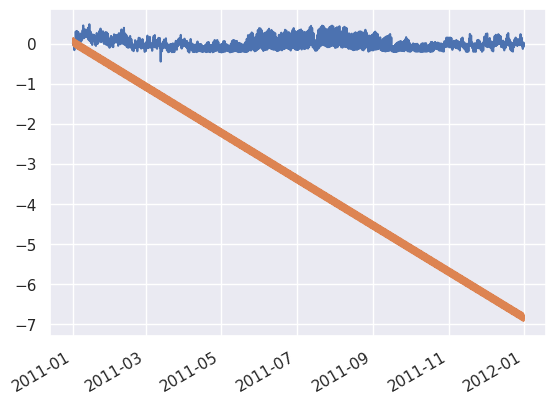

In [17]:
# get predictions and confidence intervals on the test set
pred = model.get_prediction(start=test_df.index[0], end=test_df.index[-1], dynamic=False)
pred_ci = pred.conf_int()

# plot test and prediction
fig, ax = plt.subplots()
# ax.plot(train_df['load'], label='train')
ax.plot(test_df['load'], label='test')
ax.plot(pred.predicted_mean, label='prediction')
# ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
fig.autofmt_xdate()


# Fit a prophet model

In [80]:
# fit prophet model on the train set
from prophet import Prophet
# fit prophet model
m  = Prophet()

train_df = train_df.reset_index()
train_df = train_df.rename(columns={'timestamp': 'ds', 'load': 'y'})
test_df = test_df.reset_index()
test_df = test_df.rename(columns={'timestamp': 'ds', 'load': 'y'})

m.fit(train_df)

# make predictions
future = test_df[['ds']]
forecast = m.predict(future)




18:25:37 - cmdstanpy - INFO - Chain [1] start processing
18:26:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE:  258565.7973
MAE:  219948.9875
R2:  0.2478
MSE:  66856271520.1588


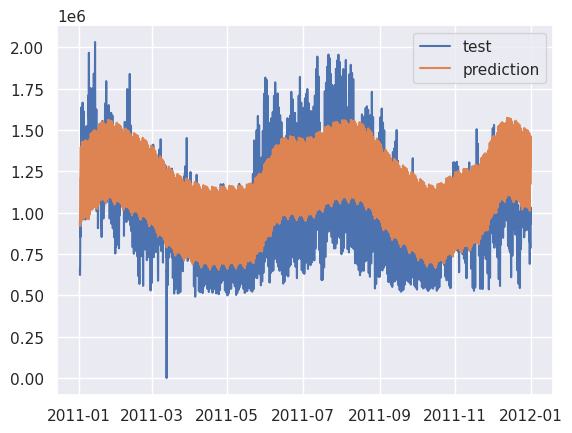

In [81]:
# plot predictions
fig, ax = plt.subplots()
# ax.plot(train_df['ds'], train_df['y'], label='train')
ax.plot(test_df['ds'], test_df['y'], label='test')
ax.plot(forecast['ds'], forecast['yhat'], label='prediction')
ax.legend()

# get error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print('RMSE: ', round(np.sqrt(mean_squared_error(test_df['y'], forecast['yhat'])), 4))
print('MAE: ', round(mean_absolute_error(test_df['y'], forecast['yhat']), 4))
print('R2: ', round(r2_score(test_df['y'], forecast['yhat']), 4))
print('MSE: ', round(mean_squared_error(test_df['y'], forecast['yhat']), 4))

In [83]:
# get waic anc dic of the model
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/7 [00:00<?, ?it/s]

18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing
18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mdape,smape,coverage
0,36 days 12:00:00,8.980680e+10,299677.830944,241576.946052,0.185610,0.213117,0.563112
1,36 days 13:00:00,8.988884e+10,299814.675626,241691.401821,0.185610,0.213154,0.562622
2,36 days 14:00:00,9.000004e+10,300000.060563,241834.745565,0.185610,0.213196,0.562296
3,36 days 15:00:00,9.013200e+10,300219.916017,241999.545029,0.185610,0.213242,0.561970
4,36 days 16:00:00,9.025787e+10,300429.483875,242149.593194,0.185610,0.213266,0.561644
...,...,...,...,...,...,...,...
7880,364 days 20:00:00,8.690654e+10,294799.148328,232381.371713,0.187410,0.214910,0.833823
7881,364 days 21:00:00,8.697503e+10,294915.292277,232473.077457,0.187469,0.214947,0.833659
7882,364 days 22:00:00,8.703254e+10,295012.779776,232546.861986,0.187555,0.214980,0.833496
7883,364 days 23:00:00,8.707087e+10,295077.727068,232607.207030,0.187555,0.215022,0.833333


# Bottom-up approach with prophet

> Benchmarking:
> - forecasting of the sum of the series with the info of each one of the sub levels
> - forecasting of the sum of the series with all of the child info and a lot of models
> - forecasting of the whole series with a lack of information on some base series (input is a partial sum)
> - repeat on the mid level (one the basis may be lacking), take out E12, E21, E25
> add the inference time to the benchmarking

In [75]:
# takes 1-2 minutes to execute
def df_formatting(df):
    """
    Input: dataframe in the load.csv format
    Output: two dataframes with a line per meter_id, with the following columns
    - meter_id
    - timesteps: array of timesteps
    - load: array of load values
    The train dataset goes up to the end of 2010, and the test df contains the whole 2011 year
    """
    new_df_train = pd.DataFrame(columns=['meter_id', 'timesteps', 'load'])
    new_df_test = pd.DataFrame(columns=['meter_id', 'timesteps', 'load'])
    meter_id = 0
    timesteps_train, load_train = "", ""
    timesteps_test, load_test = "", ""
    for _,line in df.iterrows():
        current_id = line['meter_id']
        if current_id != meter_id:
            if meter_id != 0:
                new_df_train = new_df_train.append({'meter_id': meter_id, 'timesteps': timesteps_train, 'load': load_train}, ignore_index=True)
                new_df_test = new_df_test.append({'meter_id': meter_id, 'timesteps': timesteps_test, 'load': load_test}, ignore_index=True)
            meter_id = current_id
            timesteps_train, load_train = [], []
            timesteps_test, load_test = [], []
        for hour in range(1, 25):
            month, day, year = line['date'].split('/')
            if int(year) < 2011:
                timesteps_train.append(datetime(int(year), int(month), int(day), hour - 1, 0))
                load_train.append(line['h'+str(hour)])
            else:
                timesteps_test.append(datetime(int(year), int(month), int(day), hour - 1, 0))
                load_test.append(line['h'+str(hour)])
    return new_df_train, new_df_test

train, test = df_formatting(load)

In [76]:
models = []
predictions = []

for i, row in train.iterrows():
    print('Time series: ', i)
    timesteps = row['timesteps']
    load = row['load']

    # fit a prophet model on eah one of the rows
    m  = Prophet()
    df = pd.DataFrame({'ds': timesteps, 'y': load})
    m.fit(df)
    models.append(m)

    # make predictions
    future = test_df[['ds']]
    forecast = m.predict(future)
    predictions.append(list(forecast['yhat']))


Time series:  0


16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing


Time series:  1


16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing


Time series:  2


16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing


Time series:  3


16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing


Time series:  4


16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing


Time series:  5


16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing


Time series:  6


16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  7


16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing


Time series:  8


16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  9


16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing


Time series:  10


16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing


Time series:  11


16:18:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing


Time series:  12


16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing


Time series:  13


16:20:02 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing


Time series:  14


16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:50 - cmdstanpy - INFO - Chain [1] done processing


Time series:  15


16:20:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing


Time series:  16


16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing


Time series:  17


16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:59 - cmdstanpy - INFO - Chain [1] done processing


Time series:  18


16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing


Time series:  19


16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing


Time series:  20


16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing


Time series:  21


16:23:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing


Time series:  22


16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing


Time series:  23


16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing


Time series:  24


16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing


Time series:  25


16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing


Time series:  26


16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing


Time series:  27


16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing


Time series:  28


16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing


Time series:  29


16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:46 - cmdstanpy - INFO - Chain [1] done processing


Time series:  30


16:27:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing


Time series:  31


16:28:17 - cmdstanpy - INFO - Chain [1] start processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing


Time series:  32


16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  33


16:29:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:14 - cmdstanpy - INFO - Chain [1] done processing


Time series:  34


16:30:18 - cmdstanpy - INFO - Chain [1] start processing
16:30:41 - cmdstanpy - INFO - Chain [1] done processing


Time series:  35


16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:05 - cmdstanpy - INFO - Chain [1] done processing


Time series:  36


16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing


Time series:  37


16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing


Time series:  38


16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing


Time series:  39


16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  40


16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing


Time series:  41


16:33:13 - cmdstanpy - INFO - Chain [1] start processing
16:33:36 - cmdstanpy - INFO - Chain [1] done processing


Time series:  42


16:33:40 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing


Time series:  43


16:34:03 - cmdstanpy - INFO - Chain [1] start processing
16:34:20 - cmdstanpy - INFO - Chain [1] done processing


Time series:  44


16:34:24 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing


Time series:  45


16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing


Time series:  46


16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:37 - cmdstanpy - INFO - Chain [1] done processing


Time series:  47


16:35:41 - cmdstanpy - INFO - Chain [1] start processing
16:36:05 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing


Time series:  48


16:36:10 - cmdstanpy - INFO - Chain [1] done processing


Time series:  49


16:36:14 - cmdstanpy - INFO - Chain [1] start processing
16:36:39 - cmdstanpy - INFO - Chain [1] done processing


Time series:  50


16:36:44 - cmdstanpy - INFO - Chain [1] start processing
16:37:06 - cmdstanpy - INFO - Chain [1] done processing


Time series:  51


16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:27 - cmdstanpy - INFO - Chain [1] done processing


Time series:  52


16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing


Time series:  53


16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:32 - cmdstanpy - INFO - Chain [1] done processing


Time series:  54


16:38:36 - cmdstanpy - INFO - Chain [1] start processing
16:39:04 - cmdstanpy - INFO - Chain [1] done processing


Time series:  55


16:39:08 - cmdstanpy - INFO - Chain [1] start processing
16:39:26 - cmdstanpy - INFO - Chain [1] done processing


Time series:  56


16:39:31 - cmdstanpy - INFO - Chain [1] start processing
16:39:53 - cmdstanpy - INFO - Chain [1] done processing


Time series:  57


16:39:58 - cmdstanpy - INFO - Chain [1] start processing
16:40:26 - cmdstanpy - INFO - Chain [1] done processing


Time series:  58


16:40:31 - cmdstanpy - INFO - Chain [1] start processing
16:40:58 - cmdstanpy - INFO - Chain [1] done processing


Time series:  59


16:41:02 - cmdstanpy - INFO - Chain [1] start processing
16:41:23 - cmdstanpy - INFO - Chain [1] done processing


Time series:  60


16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:53 - cmdstanpy - INFO - Chain [1] done processing


Time series:  61


16:41:57 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing


Time series:  62


16:42:22 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing


Time series:  63


16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:43:09 - cmdstanpy - INFO - Chain [1] done processing


Time series:  64


16:43:13 - cmdstanpy - INFO - Chain [1] start processing
16:43:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  65


16:43:43 - cmdstanpy - INFO - Chain [1] start processing
16:44:12 - cmdstanpy - INFO - Chain [1] done processing


Time series:  66


16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:19 - cmdstanpy - INFO - Chain [1] done processing


Time series:  67


16:44:24 - cmdstanpy - INFO - Chain [1] start processing
16:44:42 - cmdstanpy - INFO - Chain [1] done processing
16:44:44 - cmdstanpy - INFO - Chain [1] start processing


Time series:  68


16:44:45 - cmdstanpy - INFO - Chain [1] done processing


Time series:  69


16:44:49 - cmdstanpy - INFO - Chain [1] start processing
16:45:12 - cmdstanpy - INFO - Chain [1] done processing


Time series:  70


16:45:16 - cmdstanpy - INFO - Chain [1] start processing
16:45:35 - cmdstanpy - INFO - Chain [1] done processing


Time series:  71


16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:46:05 - cmdstanpy - INFO - Chain [1] done processing


Time series:  72


16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:44 - cmdstanpy - INFO - Chain [1] done processing


Time series:  73


16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing


Time series:  74


16:47:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing


Time series:  75


16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing


Time series:  76


16:49:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing


Time series:  77


16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:54 - cmdstanpy - INFO - Chain [1] done processing


Time series:  78


16:51:01 - cmdstanpy - INFO - Chain [1] start processing
16:51:36 - cmdstanpy - INFO - Chain [1] done processing


Time series:  79


16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:52:09 - cmdstanpy - INFO - Chain [1] done processing


Time series:  80


16:52:15 - cmdstanpy - INFO - Chain [1] start processing
16:52:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  81


16:52:56 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing


Time series:  82


16:53:30 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing


Time series:  83


16:54:13 - cmdstanpy - INFO - Chain [1] start processing
16:54:51 - cmdstanpy - INFO - Chain [1] done processing


Time series:  84


16:54:58 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing


Time series:  85


16:55:43 - cmdstanpy - INFO - Chain [1] start processing
16:56:23 - cmdstanpy - INFO - Chain [1] done processing


Time series:  86


16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:57:03 - cmdstanpy - INFO - Chain [1] done processing


Time series:  87


16:57:11 - cmdstanpy - INFO - Chain [1] start processing
16:57:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  88


16:57:45 - cmdstanpy - INFO - Chain [1] start processing
16:58:08 - cmdstanpy - INFO - Chain [1] done processing


Time series:  89


16:58:14 - cmdstanpy - INFO - Chain [1] start processing
16:58:48 - cmdstanpy - INFO - Chain [1] done processing


Time series:  90


16:58:55 - cmdstanpy - INFO - Chain [1] start processing
16:59:18 - cmdstanpy - INFO - Chain [1] done processing


Time series:  91


16:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing


Time series:  92


17:00:20 - cmdstanpy - INFO - Chain [1] start processing
17:00:48 - cmdstanpy - INFO - Chain [1] done processing


Time series:  93


17:00:56 - cmdstanpy - INFO - Chain [1] start processing
17:01:34 - cmdstanpy - INFO - Chain [1] done processing


Time series:  94


17:01:40 - cmdstanpy - INFO - Chain [1] start processing
17:02:20 - cmdstanpy - INFO - Chain [1] done processing


Time series:  95


17:02:27 - cmdstanpy - INFO - Chain [1] start processing
17:03:03 - cmdstanpy - INFO - Chain [1] done processing


Time series:  96


17:03:10 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing


Time series:  97


17:04:22 - cmdstanpy - INFO - Chain [1] start processing
17:05:22 - cmdstanpy - INFO - Chain [1] done processing


Time series:  98


17:05:28 - cmdstanpy - INFO - Chain [1] start processing
17:06:08 - cmdstanpy - INFO - Chain [1] done processing


Time series:  99


17:06:15 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing


Time series:  100


17:06:53 - cmdstanpy - INFO - Chain [1] start processing
17:07:30 - cmdstanpy - INFO - Chain [1] done processing


Time series:  101


17:07:36 - cmdstanpy - INFO - Chain [1] start processing
17:08:20 - cmdstanpy - INFO - Chain [1] done processing


Time series:  102


17:08:28 - cmdstanpy - INFO - Chain [1] start processing
17:09:03 - cmdstanpy - INFO - Chain [1] done processing


Time series:  103


17:09:10 - cmdstanpy - INFO - Chain [1] start processing
17:09:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  104


17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:10:20 - cmdstanpy - INFO - Chain [1] done processing


Time series:  105


17:10:28 - cmdstanpy - INFO - Chain [1] start processing
17:11:17 - cmdstanpy - INFO - Chain [1] done processing


Time series:  106


17:11:24 - cmdstanpy - INFO - Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing


Time series:  107


17:12:02 - cmdstanpy - INFO - Chain [1] start processing
17:12:47 - cmdstanpy - INFO - Chain [1] done processing


Time series:  108


17:12:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:28 - cmdstanpy - INFO - Chain [1] done processing


Time series:  109


17:13:37 - cmdstanpy - INFO - Chain [1] start processing
17:14:08 - cmdstanpy - INFO - Chain [1] done processing


Time series:  110


17:14:14 - cmdstanpy - INFO - Chain [1] start processing
17:15:04 - cmdstanpy - INFO - Chain [1] done processing


Time series:  111


17:15:11 - cmdstanpy - INFO - Chain [1] start processing
17:15:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  112


17:15:54 - cmdstanpy - INFO - Chain [1] start processing
17:16:24 - cmdstanpy - INFO - Chain [1] done processing


Time series:  113


17:16:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:22 - cmdstanpy - INFO - Chain [1] done processing


Time series:  114


17:17:29 - cmdstanpy - INFO - Chain [1] start processing
17:18:28 - cmdstanpy - INFO - Chain [1] done processing


Time series:  115


17:18:36 - cmdstanpy - INFO - Chain [1] start processing
17:19:25 - cmdstanpy - INFO - Chain [1] done processing


Time series:  116


17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:40 - cmdstanpy - INFO - Chain [1] done processing


Time series:  117


17:20:47 - cmdstanpy - INFO - Chain [1] start processing
17:21:26 - cmdstanpy - INFO - Chain [1] done processing


Time series:  118


17:21:33 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing


Time series:  119


17:22:13 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing


Time series:  120


17:23:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:03 - cmdstanpy - INFO - Chain [1] done processing


Time series:  121


17:24:10 - cmdstanpy - INFO - Chain [1] start processing
17:24:50 - cmdstanpy - INFO - Chain [1] done processing


Time series:  122


17:24:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:39 - cmdstanpy - INFO - Chain [1] done processing


Time series:  123


17:25:48 - cmdstanpy - INFO - Chain [1] start processing
17:26:46 - cmdstanpy - INFO - Chain [1] done processing


Time series:  124


17:26:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:19 - cmdstanpy - INFO - Chain [1] done processing


Time series:  125


17:27:25 - cmdstanpy - INFO - Chain [1] start processing
17:27:48 - cmdstanpy - INFO - Chain [1] done processing


Time series:  126


17:27:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing


Time series:  127


17:28:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:21 - cmdstanpy - INFO - Chain [1] done processing


Time series:  128


17:29:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:04 - cmdstanpy - INFO - Chain [1] done processing


Time series:  129


17:30:10 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing


Time series:  130


17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing


Time series:  131


17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing


Time series:  132


17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing


Time series:  133


17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing


Time series:  134


17:33:01 - cmdstanpy - INFO - Chain [1] start processing
17:33:44 - cmdstanpy - INFO - Chain [1] done processing


Time series:  135


17:33:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing


Time series:  136


17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  137


17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:12 - cmdstanpy - INFO - Chain [1] done processing


Time series:  138


17:35:18 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  139


17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  140


17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing


Time series:  141


17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing


Time series:  142


17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing


Time series:  143


17:39:33 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing


Time series:  144


17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:41:00 - cmdstanpy - INFO - Chain [1] done processing


Time series:  145


17:41:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing


Time series:  146


17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing


Time series:  147


17:43:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing


Time series:  148


17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing


Time series:  149
Time series:  150


17:46:00 - cmdstanpy - INFO - Chain [1] start processing
17:46:57 - cmdstanpy - INFO - Chain [1] done processing


Time series:  151


17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing


Time series:  152


17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing


Time series:  153


17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing


Time series:  154


17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:51:39 - cmdstanpy - INFO - Chain [1] done processing


Time series:  155


17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing


Time series:  156


17:52:24 - cmdstanpy - INFO - Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing


Time series:  157


17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:43 - cmdstanpy - INFO - Chain [1] done processing


Time series:  158


17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:53:18 - cmdstanpy - INFO - Chain [1] done processing


Time series:  159


17:53:23 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing


Time series:  160


17:53:44 - cmdstanpy - INFO - Chain [1] start processing
17:53:49 - cmdstanpy - INFO - Chain [1] done processing


Time series:  161


17:53:55 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing


Time series:  162


17:54:02 - cmdstanpy - INFO - Chain [1] start processing
17:54:07 - cmdstanpy - INFO - Chain [1] done processing


Time series:  163


17:54:12 - cmdstanpy - INFO - Chain [1] start processing
17:54:17 - cmdstanpy - INFO - Chain [1] done processing
17:54:21 - cmdstanpy - INFO - Chain [1] start processing


Time series:  164


17:54:21 - cmdstanpy - INFO - Chain [1] done processing


Time series:  165


17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing


Time series:  166


17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing


Time series:  167


17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
# create an len(train) x len(test) matrix with the predictions 
predictions = np.array(predictions)
# sum the predictions to get the final prediction
predictions = np.sum(predictions, axis=0)
print(predictions.shape)

(8735,)


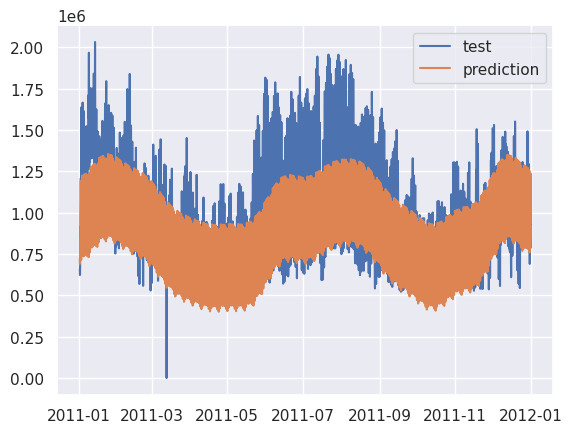

In [78]:

# put the predictions in a dataframe 
predictions_df = pd.DataFrame({'ds': test_df['ds'], 'y': predictions})
# plot
fig, ax = plt.subplots()
ax.plot(test_df['ds'], test_df['y'], label='test')
ax.plot(predictions_df['ds'], predictions_df['y'], label='prediction')
ax.legend()

In [79]:
# compute mean of error metrics at each level

# top level 
print('RMSE: ', round(np.sqrt(mean_squared_error(test_df['y'], predictions_df['y'])), 4))
print('MAE: ', round(mean_absolute_error(test_df['y'], predictions_df['y']), 4))

RMSE:  241642.4237
MAE:  180703.7439


# Top-down approach with prophet

In [ ]:
# average historical proportions

# for each time series, compute the average historical proportion


# proportion of the historical averages
